In [7]:
import os
import json
import csv
import numpy as np
import tensorflow as tf
import torch
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report, roc_curve, auc

class DataGenerator(Sequence):
    def __init__(self, data, batch_size, bert_tokenizer, bert_model, label_binarizer, max_length=77, is_training=True, is_labeled=True):
        self.data = data
        self.batch_size = batch_size
        self.bert_tokenizer = bert_tokenizer
        self.bert_model = bert_model
        self.label_binarizer = label_binarizer
        self.max_length = max_length
        self.indices = np.arange(len(self.data))
        self.is_training = is_training  # New attribute to indicate training mode
        self.is_labeled = is_labeled  # New flag to indicate if data is labeled

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.data[k] for k in batch_indices]

        if self.is_labeled:
            X, y = self.preprocess_data(batch)
            if self.is_training:
                return X, y
            else:
                batch_ids = [sample["id"] for sample in batch]
                return X, y, batch_ids
        else:
            X = self.preprocess_data(batch, labeled=False)
            if not self.is_training:
                batch_ids = [sample["id"] for sample in batch]
            return X, batch_ids 
        

    def preprocess_data(self, batch, labeled=True):
        texts = [sample["text"] for sample in batch]

        if labeled and self.label_binarizer:
            labels = [sample.get("label", []) for sample in batch]
            default_label = ['None']
            labels = [label if label else default_label for label in labels]
            y = self.label_binarizer.transform(labels)
        else:
            y = None

        # Tokenize texts and prepare input tensors
        encoded_inputs = self.bert_tokenizer.batch_encode_plus(
            texts, 
            add_special_tokens=True, 
            max_length=self.max_length, 
            padding=True, 
            truncation=True, 
            return_tensors='pt'
        )
        input_ids = encoded_inputs['input_ids']
        attention_mask = encoded_inputs['attention_mask']

        # Generate text embeddings using BERT
        with torch.no_grad():
            outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
            text_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().detach().numpy()

        if labeled:
            return text_embeddings, y
        else:
            return text_embeddings

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

class MemeClassification:
    def __init__(self):
        self.label_binarizer = LabelBinarizer()
        # Initialize BERT tokenizer and model
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.model = None
        self.file_paths = {
            'train': '/Users/jamessmith/Desktop/Desktop/PhD-4/dataset/train_data_final.json', 
            'dev': '/Users/jamessmith/Desktop/Desktop/PhD-4/dataset/dev_data_final.json',
        }

    def load_and_preprocess_data(self, data_type, sample_size=None):
        # Select the file path based on the data_type
        json_file_path = self.file_paths.get(data_type)
        if not json_file_path:
            raise ValueError(f"Invalid data type: {data_type}")

        with open(json_file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        if sample_size:
            data = np.random.choice(data, sample_size, replace=False)

        # Handling labels differently based on data_type
        if data_type == 'test':
            # For 'test' data, labels may not be present
            labels = [sample.get("label", None) for sample in data]
            # Keep only samples with labels (filter out None)
            labels = [label for label in labels if label is not None]
        else:
            # For 'train' and 'dev' data, assign a default label if none exist
            default_label = ['None']
            labels = [sample.get("label", []) for sample in data]
            labels = [label if label else default_label for label in labels]

        self.label_binarizer.fit(labels)

        return data
    
    def explore_data(self, data_type='train', sample_size=None, examples_to_show=2):
        # Load data
        data = self.load_and_preprocess_data(data_type, sample_size)
        print(f"Total number of samples: {len(data)}")

        # Unique labels
        unique_labels = self.label_binarizer.classes_
        print(f"Total number of unique labels: {len(unique_labels)}")
        print("Unique labels:", unique_labels)

        # Initialize a DataGenerator with a small batch of data
        small_batch_data = data[:examples_to_show]
        data_generator = DataGenerator(small_batch_data, len(small_batch_data), self.bert_tokenizer, self.bert_model, self.label_binarizer)

        # Processed data examples
        for i, sample in enumerate(small_batch_data):
            print(f"\nSample {i+1}:")
            print("Original Text:", sample["text"])
            processed_text, _ = data_generator.preprocess_data([sample])
            print("Processed Text:", processed_text)         

    def build_model(self, num_classes=2, bert_embedding_size=768, dropout_rate=0.5, learning_rate=0.005):
        input_embedding_input = Input(shape=(bert_embedding_size,), dtype='float32', name="input_embedding")
        dense_layer = Dense(768, activation='relu')(input_embedding_input)
        dropout_layer = Dropout(dropout_rate)(dense_layer)
        output_layer = Dense(1, activation='sigmoid')(dense_layer)  # Binary output

        self.model = Model(inputs=input_embedding_input, outputs=output_layer)
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


    def train_model(self, save_model_path, batch_size=64, data_type='train', epochs=5, validation_size=0.2, learning_rate=0.005, random_state=42, sample_size=None):
        data = self.load_and_preprocess_data(data_type, sample_size)

        # Split data into training and validation sets
        X_train_indices, X_val_indices = train_test_split(
            range(len(data)), test_size=validation_size, random_state=random_state
        )

        # Generate training and validation data using indices
        train_data = [data[i] for i in X_train_indices]
        val_data = [data[i] for i in X_val_indices]

        # Initialize data generators
        train_generator = DataGenerator(train_data, batch_size, self.bert_tokenizer, self.bert_model, self.label_binarizer, is_training=True)
        val_generator = DataGenerator(val_data, batch_size, self.bert_tokenizer, self.bert_model, self.label_binarizer, is_training=True)

        #build  the model
        self.build_model(num_classes=len(self.label_binarizer.classes_), dropout_rate=0.5, learning_rate=learning_rate)
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

        #train the model
        history = self.model.fit(
            train_generator, epochs=epochs, validation_data=val_generator, callbacks=[early_stopping]
        )

        # Save model
        self.model.save_weights(save_model_path)
        print(f"Model saved at {save_model_path}")

        return history
   
    def plot_training_history(self, history):
        plt.figure(figsize=(10, 4))
        
        #plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='upper left')

        #plot loss 
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.tight_layout()
        plt.show() 
        
    def calculate_roc_curve(self, true_labels, predicted_probs):
        # Assuming 'viral' is the positive label
        pos_label = 'viral'
        true_labels_binary = [1 if label == pos_label else 0 for label in true_labels]
        fpr, tpr, thresholds = roc_curve(true_labels_binary, predicted_probs)
        roc_auc = auc(fpr, tpr)
        return fpr, tpr, roc_auc

    def plot_roc_curve(self, fpr, tpr, roc_auc):
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()


    def evaluate_model(self, batch_size, save_model_path, num_classes, output_json_path, data_type='dev', learning_rate=0.005):
        # Load and preprocess test data
        dev_data = self.load_and_preprocess_data(data_type)

        # Initialize data generator for the test data in evaluation mode
        test_generator = DataGenerator(dev_data, batch_size, self.bert_tokenizer, self.bert_model, self.label_binarizer, is_training=False)

        # Build the model and load saved weights
        self.build_model(num_classes=len(self.label_binarizer.classes_), dropout_rate=0.5, learning_rate=learning_rate)
        self.model.load_weights(save_model_path)

        # Variables for metrics calculation
        true_labels_all = []
        predicted_labels_all = []
        predicted_probs_all = []  # Store predicted probabilities for calculating ROC curve

        results = [] 
        for X, y_true, batch_ids in test_generator:
            y_pred = self.model.predict(X)

            # Iterate over predictions in the batch
            for sample_id, prediction, true_label in zip(batch_ids, y_pred, y_true):
                gold_label = self.label_binarizer.classes_[0] if true_label == 0 else self.label_binarizer.classes_[1]
                predicted_label = self.label_binarizer.classes_[0] if prediction < 0.5 else self.label_binarizer.classes_[1]

                # Probability of the positive class
                positive_prob = float(prediction[0])  # Assuming the model outputs a single probability per sample
                predicted_label_prob = positive_prob if predicted_label == self.label_binarizer.classes_[1] else 1 - positive_prob
                
                true_labels_all.append(gold_label)
                predicted_labels_all.append(predicted_label)
                predicted_probs_all.append(positive_prob)

                results.append({
                    'id': sample_id,
                    'true_label': gold_label,
                    'predicted_label': predicted_label,            
                    'predicted_label_probability': predicted_label_prob               
                })     

        # Calculate ROC curve
        fpr, tpr, roc_auc = self.calculate_roc_curve(true_labels_all, predicted_probs_all)

        # Plot ROC curve
        self.plot_roc_curve(fpr, tpr, roc_auc)

        # Print classification report
        print("Classification Report:")
        print(classification_report(true_labels_all, predicted_labels_all, target_names=self.label_binarizer.classes_))

        result_file_name = f"subtask2b_dev_pred.json"
        destination_path = os.path.join(output_json_path, result_file_name)
        os.makedirs(output_json_path, exist_ok=True)
        with open(destination_path, 'w') as json_file:
            json.dump(results, json_file, indent=4)


batch_size = 64
num_classes = 2
output_json_path = '/Users/jamessmith/Desktop/Desktop/PhD-4/dataset'
save_model_path = '/Users/jamessmith/Desktop/Desktop/PhD-4/dataset/BERT_model_weights'

BERT_meme_classifier = MemeClassification()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
BERT_meme_classifier.explore_data(data_type='dev')


Total number of samples: 1026
Total number of unique labels: 2
Unique labels: ['non viral' 'viral']

Sample 1:
Original Text: When she kisses down your neck
and on to your chest, then your
stomach.... And then.... Your...
thigh.... And on down to your knee,
then your calf:
What about the droid attack on the Wookiees?
Processed Text: [[ 4.10071164e-02 -1.85884491e-01  3.83325130e-01  1.42883807e-02
   3.32893610e-01 -5.02332412e-02 -7.46971443e-02  7.22596526e-01
  -3.36114407e-01 -3.71043831e-01 -5.97353876e-02 -4.48988765e-01
  -2.57606715e-01  1.65709823e-01  2.04859432e-02  6.61075890e-01
   1.54267505e-01 -5.30114993e-02 -9.30775478e-02  2.34624878e-01
   3.58340681e-01  1.99168734e-02  5.74977696e-02  5.38303077e-01
   1.69842601e-01 -2.47365832e-01 -3.93968672e-02  1.20461948e-01
  -4.07700956e-01 -1.08765714e-01  4.02233809e-01  3.89969721e-02
  -3.67717773e-01 -1.73590612e-02 -4.23052870e-02 -3.04996520e-01
   1.94539890e-01  6.32642880e-02  3.11871264e-02  5.22346646e-02
  -7.

Processed Text: [[ 2.68772244e-01  9.96056572e-02  5.77205062e-01 -9.15351510e-02
   2.84996778e-01 -2.00126916e-01  8.03570077e-02  3.72464359e-01
  -1.73446774e-01 -1.31512761e-01  1.77498594e-01 -3.24751705e-01
  -1.47840023e-01  1.10004768e-01 -1.35434851e-01  2.44847894e-01
   1.40934587e-01  1.34761542e-01  4.79502864e-02  4.00644809e-01
   1.85110509e-01  2.83609539e-01 -7.27173984e-02  2.26540342e-01
   2.14439690e-01 -4.47981246e-02 -2.79185474e-01  4.44000438e-02
  -2.08166078e-01 -3.64755809e-01  2.11281478e-01 -7.72765353e-02
   1.89991910e-02 -2.48777688e-01 -2.41613612e-01 -2.03042030e-01
   3.01084798e-02 -6.50411695e-02 -8.10302570e-02  2.02310294e-01
  -4.32472497e-01 -4.48652692e-02 -8.56113657e-02  1.34277910e-01
  -3.17091703e-01 -3.20566177e-01 -1.01146333e-01  1.78755835e-01
   4.61496301e-02  1.65502708e-02 -1.39172319e-02  9.93258059e-02
  -4.26490396e-01 -8.64578038e-02  4.86468524e-02  5.77481389e-01
   3.73757780e-01 -4.96697843e-01 -4.08330619e-01  1.4028954

In [9]:
history= BERT_meme_classifier.train_model(save_model_path, 
                                          batch_size=64,
                                          learning_rate=0.0001,
                                          epochs=10,
                                          data_type='dev'
                                         )


Epoch 1/10
 2/13 [===>..........................] - ETA: 43s - loss: 0.7132 - accuracy: 0.3707 

KeyboardInterrupt: 

In [ ]:
#plot the training history
BERT_meme_classifier.plot_training_history(history)

1/1 [==============================] - 0s 45ms/step


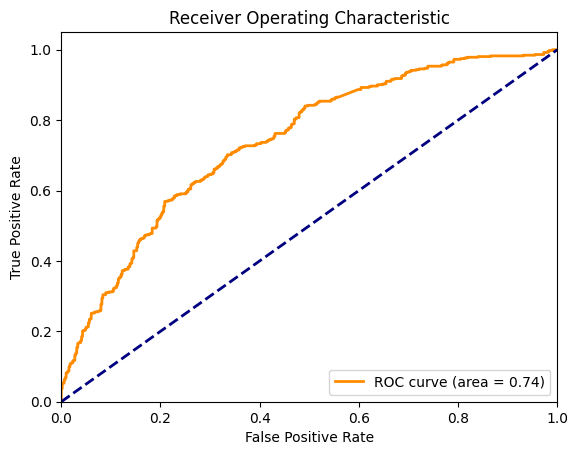

Classification Report:
              precision    recall  f1-score   support

   non viral       0.68      0.67      0.68       513
       viral       0.68      0.68      0.68       513

    accuracy                           0.68      1026
   macro avg       0.68      0.68      0.68      1026
weighted avg       0.68      0.68      0.68      1026



In [56]:
#evaluate the model using the dev data
BERT_meme_classifier.evaluate_model(batch_size, 
                                    save_model_path, 
                                    num_classes, 
                                    output_json_path, 
                                    data_type='dev'
                                    )
